In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.options.display.max_columns = None

In [2]:
gl_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-Game-Log.csv')
gl_19_20.insert(2, 'Season', '2019-2020')
gl_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Game-Log.csv')
gl_20_21.insert(2, 'Season', '2020-2021')
gl_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Game-Log.csv')
gl_21_22.insert(2, 'Season', '2021-2022')
gl_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Game-log.csv')
gl_22_23.insert(2, 'Season', '2022-2023')
gl_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Game-Log.csv')
gl_23_24.insert(2, 'Season', '2023-2024')

team_opp_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-PerGameTeamAndOpponentStats.csv')
team_opp_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Team&Opponent-Per-Game.csv')
team_opp_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Team&Opp-Per-Game.csv')
team_opp_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Team&Opponents.csv')
team_opp_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Team&Opp-Per-Game.csv')

roster_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-roster.csv')
roster_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Roster.csv')
roster_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Roster.csv')
roster_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Roster.csv')
roster_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Roster.csv')

In [3]:
# Adding a feature that tells us how much rest the Fighting Illini had before their current game

def add_rest_time(game_log):
    # Ensure the Date column is in datetime format and sorted
    game_log['Date'] = pd.to_datetime(game_log['Date'])
    game_log = game_log.sort_values(by='Date').reset_index(drop=True)
    
    # Calculate rest days
    game_log['Rest Days'] = game_log['Date'].diff().dt.days.fillna(0).astype(int)
    
    # Fix any negative or unreasonable rest days
    game_log['Rest Days'] = game_log['Rest Days'].apply(lambda x: max(x, 0))  # No negative rest days

    # Insert Rest Days at the 7th index position
    game_log.insert(8, 'Rest Days', game_log.pop('Rest Days'))
    
    return game_log

gl_19_20 = add_rest_time(gl_19_20)
gl_20_21 = add_rest_time(gl_20_21)
gl_21_20 = add_rest_time(gl_20_21)
gl_21_22 = add_rest_time(gl_21_22)
gl_22_23 = add_rest_time(gl_22_23)
gl_23_24 = add_rest_time(gl_23_24)

In [4]:
all_gl = pd.concat([gl_19_20, gl_20_21, gl_21_22, gl_22_23, gl_23_24], ignore_index=True)
all_gl = all_gl.drop(columns='Unnamed: 0')
all_gl

,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,PF,PA,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF.1,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,2019-2020,REG,Nicholls State,NaN,False,Southland,0,-3.87,W,78,70,1,0,True,1,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,2019-2020,REG,Grand Canyon,NaN,False,WAC,3,-6.32,W,83,71,2,0,False,2,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,2019-2020,REG,Arizona,21.0,True,Pac-12,2,19.49,L,69,90,2,1,False,0,1,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,2019-2020,REG,Hawaii,NaN,False,Big West,8,-1.27,W,66,53,3,1,True,1,0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,2019-2020,REG,The Citadel,NaN,False,Southern,2,-13.82,W,85,57,4,1,True,2,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-18,8:30p,2023-2024,REG,Michigan,NaN,False,Big Ten,0,5.28,W,88,73,13,4,False,1,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18
162,2024-01-21,6:09p,2023-2024,NCAA,Connecticut,1.0,True,Big East,3,26.70,L,52,77,29,9,False,0,1,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19
163,2024-01-21,1:00p,2023-2024,REG,Rutgers,NaN,False,Big Ten,0,7.41,W,86,63,14,4,True,2,0,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19
164,2024-01-24,9:00p,2023-2024,REG,Northwestern,NaN,False,Big Ten,3,12.77,L,91,96,14,5,False,0,1,31,76,0.408,11,24,0.458,18,24,0.750,20,44,14,5,3,10,15,38,69,0.551,11,18,0.611,9,13,0.692,6,31,16,6,5,5,19


In [23]:
# all_gl.to_csv(r'/Users/isaac/Desktop/personal/datadive24/Clean Datasets/All-Clean-Game-Logs.csv')

In [6]:
# Observe if Rest Days Were Correctly Calculated
all_gl['Rest Days'].unique()

array([ 0,  3,  2,  8,  6,  5,  4,  7,  1, 10, 13])

In [7]:
# Rename duplicate column names to be more concise
all_gl.rename(columns={'PF': 'Points For', 'PA' : 'Points Against', 'PF.1' : 'PF'}, inplace=True)
all_gl

,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,2019-2020,REG,Nicholls State,NaN,False,Southland,0,-3.87,W,78,70,1,0,True,1,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,2019-2020,REG,Grand Canyon,NaN,False,WAC,3,-6.32,W,83,71,2,0,False,2,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,2019-2020,REG,Arizona,21.0,True,Pac-12,2,19.49,L,69,90,2,1,False,0,1,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,2019-2020,REG,Hawaii,NaN,False,Big West,8,-1.27,W,66,53,3,1,True,1,0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,2019-2020,REG,The Citadel,NaN,False,Southern,2,-13.82,W,85,57,4,1,True,2,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-18,8:30p,2023-2024,REG,Michigan,NaN,False,Big Ten,0,5.28,W,88,73,13,4,False,1,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18
162,2024-01-21,6:09p,2023-2024,NCAA,Connecticut,1.0,True,Big East,3,26.70,L,52,77,29,9,False,0,1,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19
163,2024-01-21,1:00p,2023-2024,REG,Rutgers,NaN,False,Big Ten,0,7.41,W,86,63,14,4,True,2,0,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19
164,2024-01-24,9:00p,2023-2024,REG,Northwestern,NaN,False,Big Ten,3,12.77,L,91,96,14,5,False,0,1,31,76,0.408,11,24,0.458,18,24,0.750,20,44,14,5,3,10,15,38,69,0.551,11,18,0.611,9,13,0.692,6,31,16,6,5,5,19


In [8]:
all_gl.isna().sum()

Date                0
Time                0
Season              0
Type                0
Opponent            0
Rank              120
Ranked Match        0
Conf                1
Rest Days           0
SRS                 1
Result              0
Points For          0
Points Against      0
W                   0
L                   0
Home Game           0
Win Streak          0
Lose Streak         0
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%                 0
FT                  0
FTA                 0
FT%                 0
ORB                 0
TRB                 0
AST                 0
STL                 0
BLK                 0
TOV                 0
PF                  0
OPP FG              0
OPP FGA             0
OPP FG%             0
OPP 3P              0
OPP 3PA             0
OPP 3P%             0
OPP FT              0
OPP FTA             0
OPP FT%             0
OPP ORB             0
OPP TRB             0
OPP AST   

In [9]:
# Find the row with missing values
lindenwood = all_gl.loc[all_gl['Conf'].isna()]
lindenwood

,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,2019-2020,REG,Lindenwood,NaN,False,NaN,3,NaN,W,117,65,6,1,True,4,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [10]:
# Fill in missing conference value
lindenwood['Conf'] = 'OVC'
lindenwood

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_52552/294574576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindenwood['Conf'] = 'OVC'


,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,2019-2020,REG,Lindenwood,NaN,False,OVC,3,NaN,W,117,65,6,1,True,4,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [11]:
# Fill in missing SRS value with an estimate
lindenwood['SRS'] = 42
lindenwood

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_52552/1554679363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindenwood['SRS'] = 42


,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,2019-2020,REG,Lindenwood,NaN,False,OVC,3,42,W,117,65,6,1,True,4,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [12]:
all_gl.loc[all_gl['Conf'].isna()] = lindenwood

In [13]:
all_gl.isna().sum()

Date                0
Time                0
Season              0
Type                0
Opponent            0
Rank              120
Ranked Match        0
Conf                0
Rest Days           0
SRS                 0
Result              0
Points For          0
Points Against      0
W                   0
L                   0
Home Game           0
Win Streak          0
Lose Streak         0
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%                 0
FT                  0
FTA                 0
FT%                 0
ORB                 0
TRB                 0
AST                 0
STL                 0
BLK                 0
TOV                 0
PF                  0
OPP FG              0
OPP FGA             0
OPP FG%             0
OPP 3P              0
OPP 3PA             0
OPP 3P%             0
OPP FT              0
OPP FTA             0
OPP FT%             0
OPP ORB             0
OPP TRB             0
OPP AST   

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_52552/1866265331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])


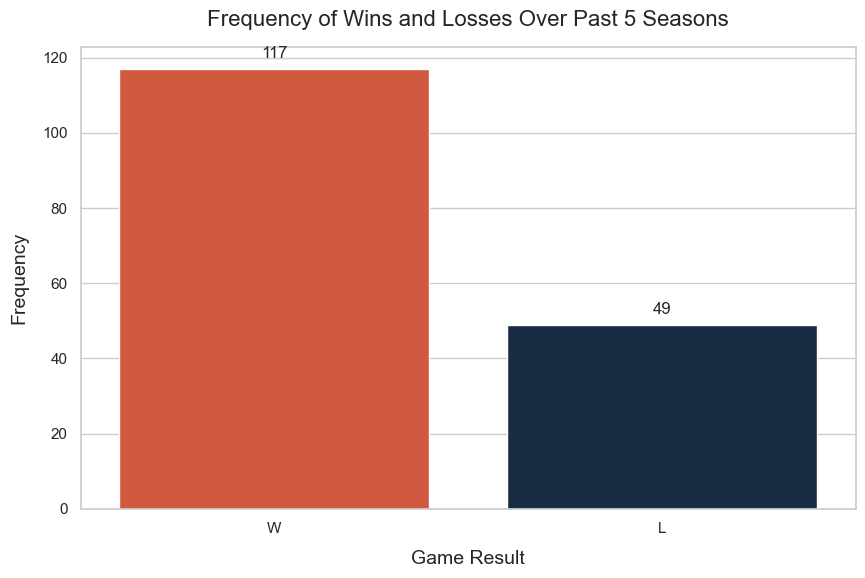

In [14]:
# Calculate the result counts
result_counts = all_gl['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Frequency of Wins and Losses Over Past 5 Seasons', fontsize=16, pad=15)

# Adding value annotations on top of the bars
for index, row in result_counts.iterrows():
    plt.text(row.name, row.Frequency + 2, row.Frequency, ha='center', va='bottom', fontsize=12)

plt.show()


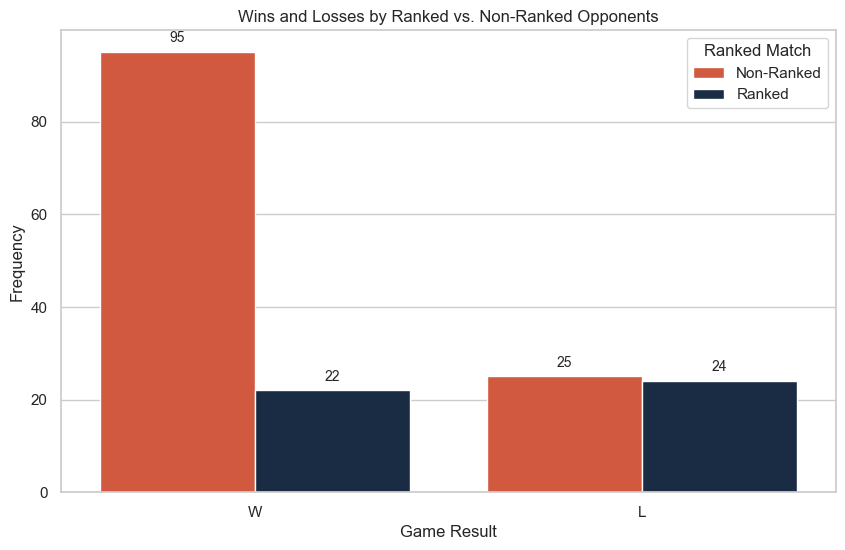

In [15]:
# Observe how well we do against ranked teams
plt.figure(figsize=(10, 6))

# Create a grouped bar plot using 'Result' and 'Ranked Match' columns
plot = sns.countplot(data=all_gl, x='Result', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds count at the top of the bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

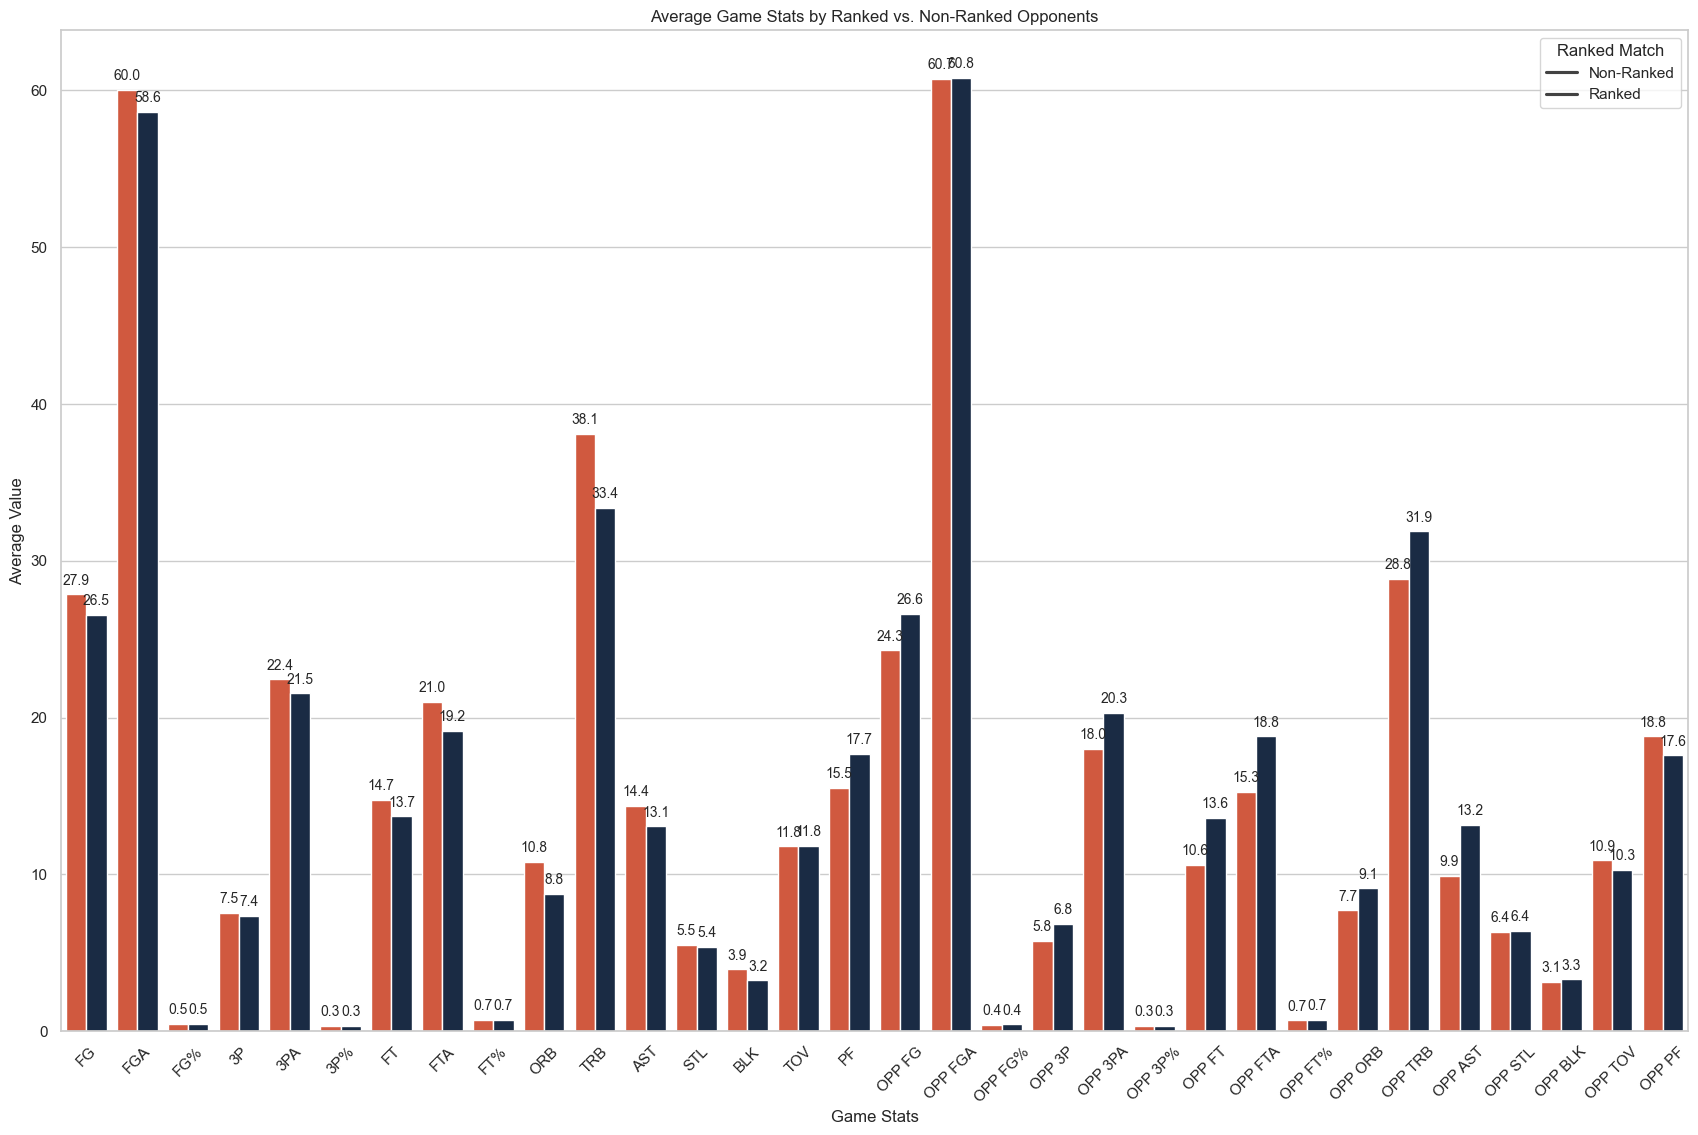

In [16]:
stats = [
    'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
    'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 
    'OPP FG', 'OPP FGA', 'OPP FG%', 'OPP 3P', 'OPP 3PA', 'OPP 3P%', 
    'OPP FT', 'OPP FTA', 'OPP FT%', 'OPP ORB', 'OPP TRB', 
    'OPP AST', 'OPP STL', 'OPP BLK', 'OPP TOV', 'OPP PF'
]

# Calculate the mean of each stat grouped by 'Ranked Match'
avg_stats = all_gl.groupby('Ranked Match')[stats].mean().reset_index()

# Reshape the data to have each stat as a separate entry for grouped plotting
avg_stats_melted = avg_stats.melt(id_vars='Ranked Match', var_name='Stat', value_name='Average')

plt.figure(figsize=(21, 13))
plot = sns.barplot(data=avg_stats_melted, x='Stat', y='Average', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Stats')
plt.ylabel('Average Value')
plt.title('Average Game Stats by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds average value at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, fmt="%.1f", label_type='edge', padding=5, fontsize=10)

plt.xticks(rotation=45)
plt.show()

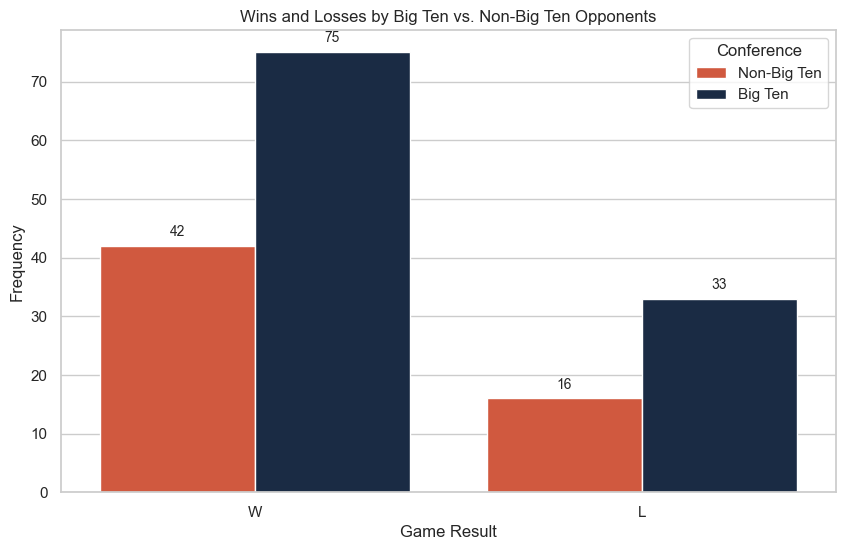

In [17]:
# What about for Conference vs. Non-Conference games
conf_gl = all_gl.copy()

conf_gl['Big_Ten_Opponent'] = conf_gl['Conf'].apply(lambda x: 'Big Ten' if x == 'Big Ten' else 'Non-Big Ten')

plt.figure(figsize=(10, 6))

# Create a grouped bar plot for Wins/Losses against Big Ten vs. Non-Big Ten teams
plot = sns.countplot(data=conf_gl, x='Result', hue='Big_Ten_Opponent', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Big Ten vs. Non-Big Ten Opponents')
plt.legend(title='Conference', labels=['Non-Big Ten', 'Big Ten'])

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

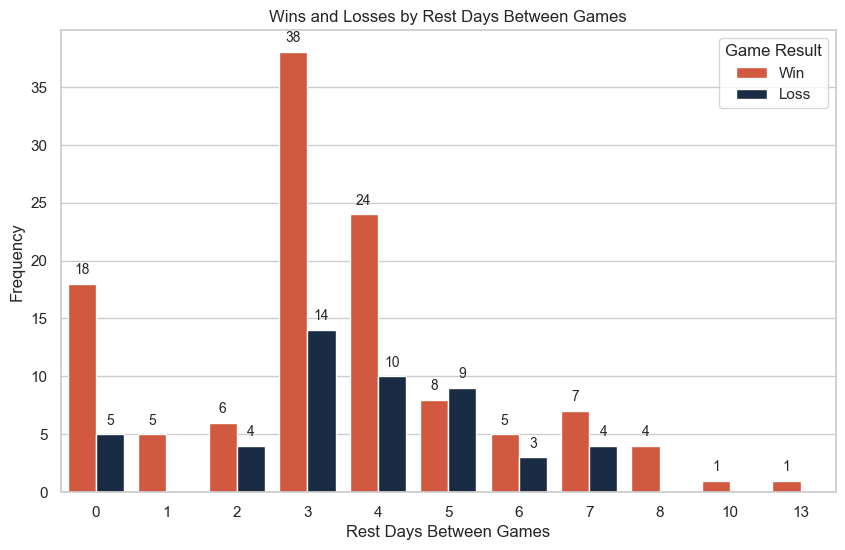

In [18]:
# Observe how the relationship between rest days and game results
plt.figure(figsize=(10, 6))

plot = sns.countplot(data=all_gl, x='Rest Days', hue='Result', palette=['#E84A27', '#13294b'])

plt.xlabel('Rest Days Between Games')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Rest Days Between Games')
plt.legend(title='Game Result', labels=['Win', 'Loss'])

# Adds count at the top of the bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

In [19]:
# show the teams we have highest chance of winning against from lowest to highest

big_ten_schools = conf_gl[conf_gl['Big_Ten_Opponent'] == 'Big Ten']

big_ten_matchups = big_ten_schools.groupby('Opponent').agg(Total_Games=('Opponent', 'size'), 
    Wins=('Result', lambda x: (x == 'W').sum())).reset_index()

big_ten_matchups['Win Percentage'] = (big_ten_matchups['Wins'] / big_ten_matchups['Total_Games']) * 100

big_ten_matchups_sorted = big_ten_matchups.sort_values(by='Win Percentage', ascending=False)

big_ten_matchups_sorted

,Opponent,Total_Games,Wins,Win Percentage
3,Michigan,8,8,100.000000
5,Minnesota,7,7,100.000000
6,Nebraska,8,8,100.000000
12,Wisconsin,8,8,100.000000
7,Northwestern,10,8,80.000000
1,Iowa,9,7,77.777778
11,Rutgers,9,6,66.666667
0,Indiana,8,5,62.500000
8,Ohio State,9,5,55.555556
4,Michigan State,8,4,50.000000


/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_52552/930791426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])
/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_52552/930791426.py:3: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])


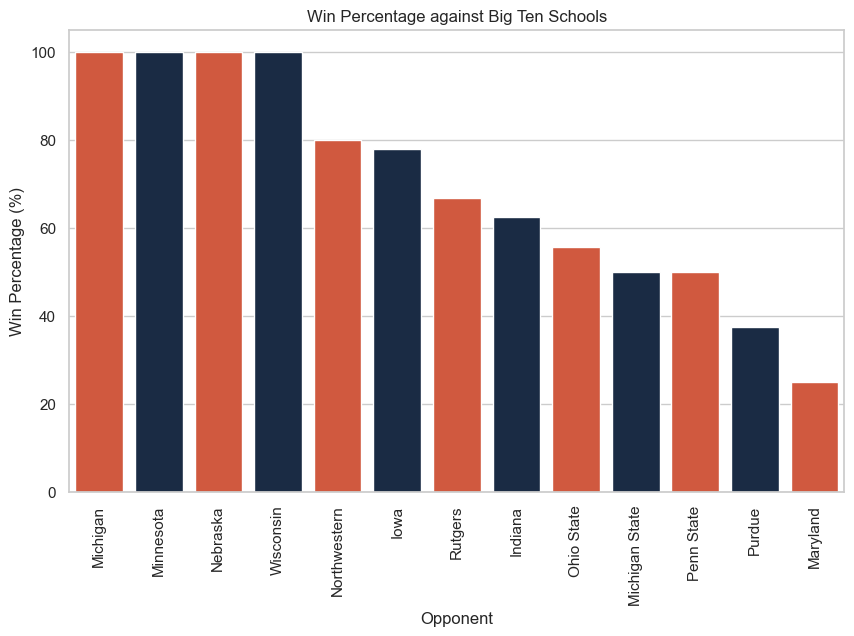

In [20]:
plt.figure(figsize=(10, 6))

sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])

plt.title('Win Percentage against Big Ten Schools')
plt.xlabel('Opponent')
plt.ylabel('Win Percentage (%)')
plt.xticks(rotation=90)

plt.show()

In [21]:
# Make a numeric only game log data frame for our correlation matrix
num_gl = all_gl.copy()
num_gl['Result'] = num_gl['Result'].apply(lambda x: 1 if x == 'W' else 0)
num_gl['Ranked Match'] = num_gl['Ranked Match'].apply(lambda x: 1 if x == True else 0)
num_gl['Home Game'] = num_gl['Home Game'].apply(lambda x: 1 if x == True else 0)
num_gl['Type'] = num_gl['Type'].astype('category').cat.codes
num_gl['Conf'] = num_gl['Conf'].astype('category').cat.codes
num_gl = num_gl.drop(columns=['Date','Time','Rank','Opponent'])
num_gl

,Season,Type,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-2020,2,0,21,0,-3.87,1,78,70,1,0,1,1,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-2020,2,0,24,3,-6.32,1,83,71,2,0,0,2,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-2020,2,1,16,2,19.49,0,69,90,2,1,0,0,1,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-2020,2,0,7,8,-1.27,1,66,53,3,1,1,1,0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-2020,2,0,20,2,-13.82,1,85,57,4,1,1,2,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2023-2024,2,0,6,0,5.28,1,88,73,13,4,0,1,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18
162,2023-2024,1,1,4,3,26.70,0,52,77,29,9,0,0,1,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19
163,2023-2024,2,0,6,0,7.41,1,86,63,14,4,1,2,0,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19
164,2023-2024,2,0,6,3,12.77,0,91,96,14,5,0,0,1,31,76,0.408,11,24,0.458,18,24,0.750,20,44,14,5,3,10,15,38,69,0.551,11,18,0.611,9,13,0.692,6,31,16,6,5,5,19


In [22]:
# Create correlation matrix
gl_corr = num_gl.corr()
gl_corr

ValueError: could not convert string to float: '2019-2020'

In [ ]:
# The variables that have the most affect on the Result column in order
result_corr = gl_corr['Result'].drop('Result')
result_corr = result_corr.abs().sort_values(ascending=False)
result_corr = result_corr.reset_index()
result_corr.columns = ['Variable', 'Correlation with Result']
result_corr


,Variable,Correlation with Result
0,Lose Streak,0.860560
1,Win Streak,0.638788
2,Points Against,0.488643
3,OPP FG%,0.471648
4,FG%,0.420372
5,Points For,0.404264
6,OPP FT,0.386908
7,SRS,0.368844
8,TRB,0.360312
9,OPP FTA,0.357548


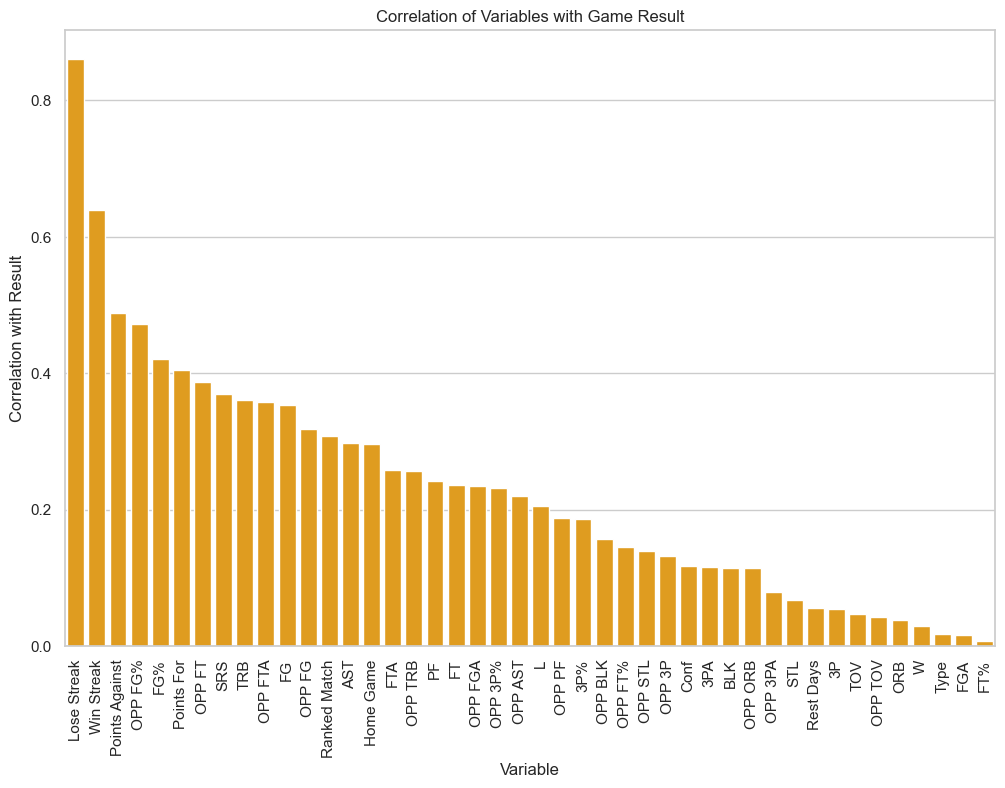

In [ ]:
# Visualization to easily view what variables had the highest correlation with result
plt.figure(figsize=(12, 8))
sns.barplot(data=result_corr, x='Variable', y='Correlation with Result', color='orange')
plt.xticks(rotation=90)
plt.title('Correlation of Variables with Game Result')
plt.xlabel('Variable')
plt.ylabel('Correlation with Result')
plt.show()

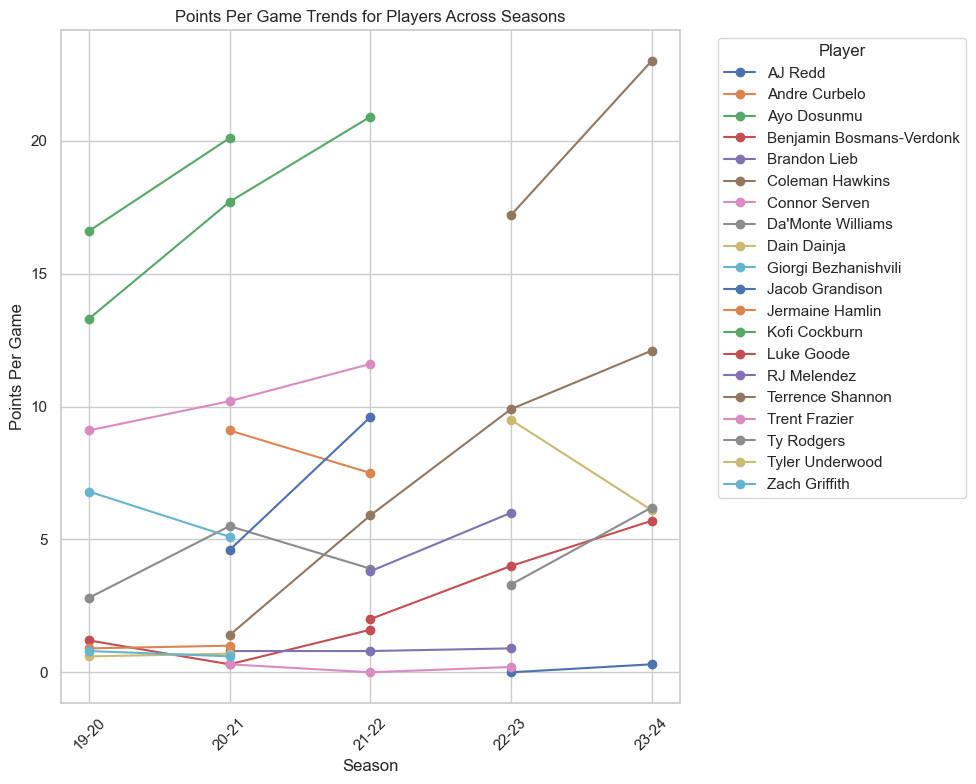

In [ ]:
import warnings
warnings.filterwarnings('ignore') #mutes warnings for 2021 and 2122 

s1920 = ['19-20', '19-20', '19-20', '19-20', '19-20', '19-20', '19-20', 
         '19-20', '19-20', '19-20' , '19-20', '19-20', '19-20', '19-20']
roster_19_20['Season'] = s1920 # add season columns to rosters for analysis later

s2021 = ['20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21'
         '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21']
roster_20_21['Season'] = s2021
roster_20_21['Season'][6] = '20-21'

s2122 = ['21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22'
         '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22']
roster_21_22['Season'] = s2122
roster_21_22['Season'][6] = '21-22'


s2223 = ['22-23', '22-23', '22-23', '22-23', '22-23',
         '22-23', '22-23', '22-23', '22-23', '22-23', 
         '22-23', '22-23', '22-23', '22-23', '22-23']
roster_22_23['Season'] = s2223

s2324 = ['23-24', '23-24', '23-24', '23-24', '23-24', '23-24',
         '23-24', '23-24', '23-24', '23-24', '23-24', '23-24'
         ,'23-24']
roster_23_24['Season'] = s2324


all_rosters = pd.concat([roster_19_20, roster_20_21, roster_21_22, roster_22_23, roster_23_24], ignore_index= True)
count_players = all_rosters['Player'].value_counts()
multiple_season = count_players[count_players > 1].index.to_list()
attributes = ['Player', 'Season', 'PTS', 'AST']
roster_performance = all_rosters[all_rosters['Player'].isin(multiple_season)][attributes]
player_pts = roster_performance.pivot(index = 'Season', columns = 'Player', values = 'PTS')
plt.figure(figsize = (10,8))
player_pts
for player in player_pts.columns :
    plt.plot(player_pts.index, player_pts[player], marker = 'o', label = player)

plt.title('Points Per Game Trends for Players Across Seasons')
plt.xlabel('Season')
plt.ylabel('Points Per Game')
plt.xticks(rotation=45)
plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

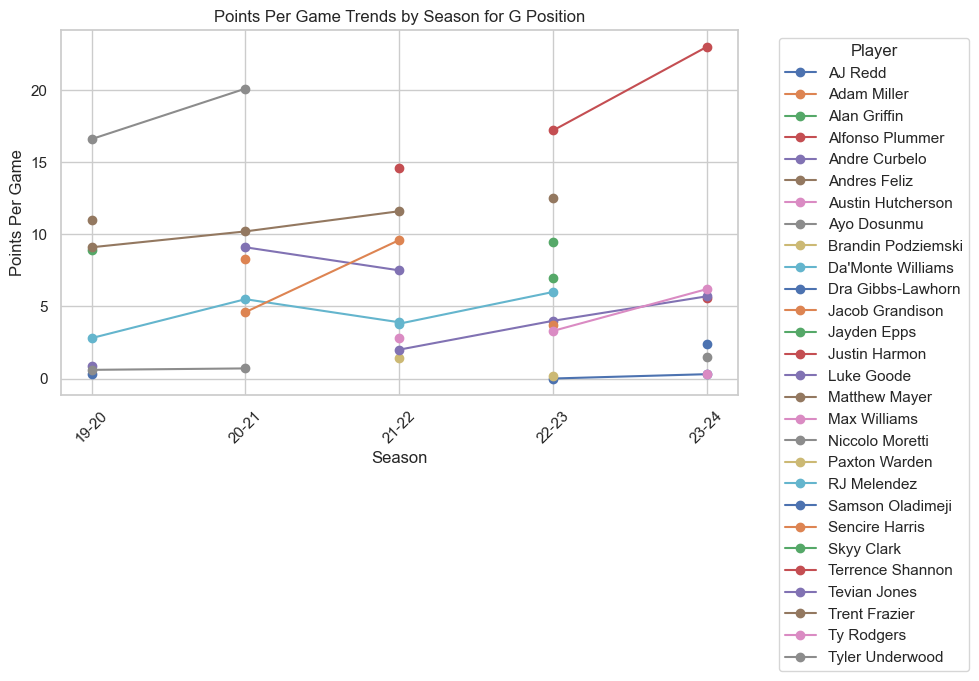

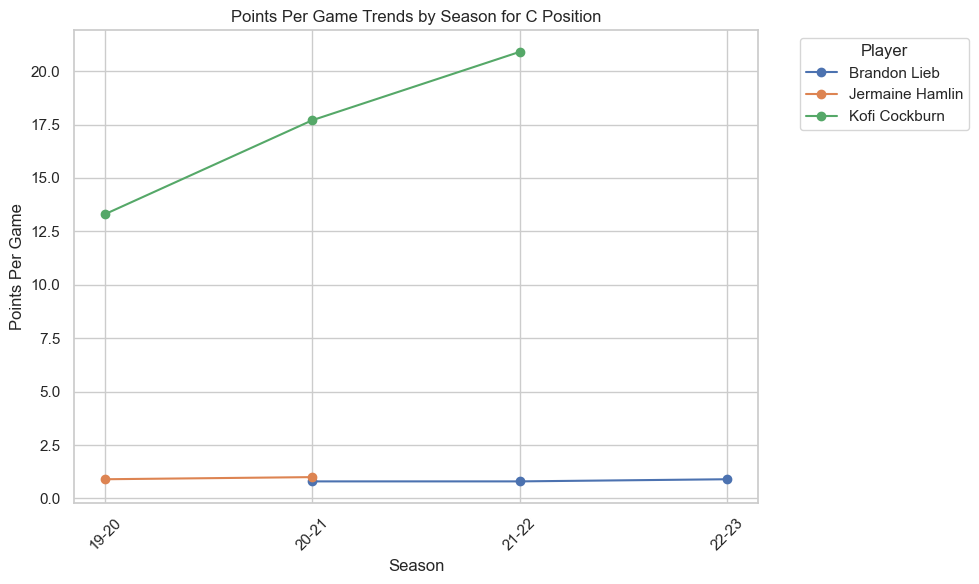

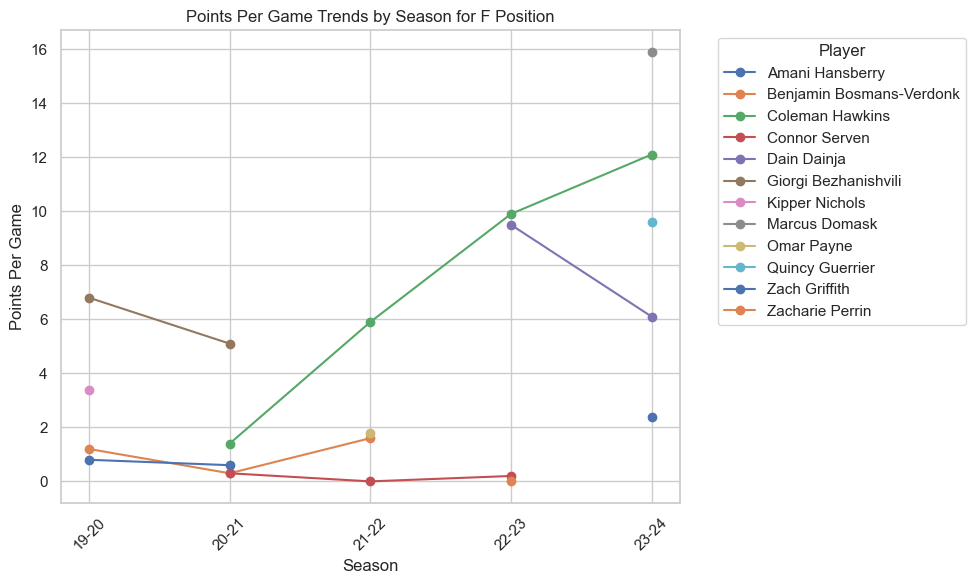

In [ ]:
if 'Pos' in all_rosters.columns and 'PTS' in all_rosters.columns: 
    position = all_rosters['Pos'].unique()
    for pos in position:
        position_data = all_rosters[all_rosters['Pos'] == pos]
        pts_for_pos = position_data.pivot(index = 'Season', columns = 'Player', values = 'PTS')
        plt.figure(figsize = (10,6))
        for player in pts_for_pos.columns: 
            plt.plot(pts_for_pos.index, pts_for_pos[player], marker = 'o', label = player)
        plt.title(f'Points Per Game Trends by Season for {pos} Position')
        plt.xlabel('Season')
        plt.ylabel('Points Per Game')
        plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
#Code below makes a linear regression model predicting points based on various metrics 

all_rosters[['Feet', 'Inches']] = all_rosters['Height'].str.split('-', expand= True)
all_rosters['Feet'] = all_rosters['Feet'].astype(int)
all_rosters['Inches'] = all_rosters['Inches'].astype(int)
all_rosters['Height(inches)'] = all_rosters['Feet'] * 12 + all_rosters['Inches']
all_rosters.drop(columns = ['Unnamed: 0']) #converts the height to inches for linear regression model and also cleans it up a little
all_rosters['Predicted PTS'] = all_rosters['PTS']

In [ ]:
x = all_rosters[['PTS', 'AST', 'Height(inches)', 'Weight']]
y = all_rosters['Predicted PTS']

drop_na = pd.concat([x, y], axis = 1).dropna()

x_c = drop_na[['PTS', 'AST', 'Height(inches)', 'Weight']]
y_c = drop_na['Predicted PTS']

x_train, x_test, y_train, y_test = train_test_split(x_c, y_c, test_size = 0.3, random_state = 42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
predictions

array([ 1.4, 16.6,  6. ,  8.9,  0.2,  8.3,  1.2,  5.9,  9.9,  0.8, 11.6,
        0.9,  9.6,  6.8,  4. , 14.6, 15.9,  3.9, 23. ,  0.8, 10.2,  7.5])

In [ ]:
y_test

22     1.4
0     16.6
49     6.0
4      8.9
55     0.2
18     8.3
10     1.2
33     5.9
46     9.9
12     0.8
31    11.6
9      0.9
62     9.6
5      6.8
53     4.0
30    14.6
60    15.9
35     3.9
59    23.0
42     0.8
16    10.2
34     7.5
Name: Predicted PTS, dtype: float64

In [ ]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("MSE = " + mse.astype(str) + "\n" + "R^2 = " + r2.astype(str))

AttributeError: 'float' object has no attribute 'astype'

In [ ]:
all_rosters

,Player,#,Class,Pos,Height,Weight,Hometown,High School,RSCI Top 100,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,Unnamed: 0,Summary,REB,Feet,Inches,Height(inches),Predicted PTS
0,Ayo Dosunmu,11,SO,G,6-5,200.0,"Chicago, IL",Morgan Park HS,32 (2018),30.0,30.0,33.5,6.5,13.5,0.484,1.0,3.3,0.296,5.6,10.2,0.544,0.520,2.6,3.4,0.755,0.6,3.7,4.3,3.3,0.8,0.2,2.7,1.7,16.6,19-20,NaN,NaN,NaN,6,5,77,16.6
1,Kofi Cockburn,21,FR,C,7-0,285.0,"Kingston, Jamaica",Oak Hill Academy,43 (2019),31.0,31.0,27.4,4.9,9.2,0.532,0.0,0.0,0.000,4.9,9.1,0.534,0.532,3.6,5.3,0.677,3.5,5.3,8.8,0.6,0.5,1.4,1.9,2.6,13.3,19-20,NaN,NaN,NaN,7,0,84,13.3
2,Andres Feliz,10,SR,G,6-2,195.0,"Guachupita, Dominican Republic",West Oaks (FL),NaN,31.0,15.0,26.8,3.9,8.5,0.460,0.5,2.0,0.274,3.4,6.5,0.517,0.492,2.6,3.4,0.769,1.0,4.0,5.0,2.9,0.7,0.0,1.4,1.7,11.0,19-20,NaN,NaN,NaN,6,2,74,11.0
3,Trent Frazier,1,JR,G,6-2,175.0,"Wellington, FL",Wellington High School,NaN,31.0,30.0,30.5,2.8,8.5,0.327,1.6,5.3,0.309,1.1,3.2,0.357,0.424,1.9,2.2,0.853,0.2,2.0,2.2,1.9,0.9,0.0,0.9,2.5,9.1,19-20,NaN,NaN,NaN,6,2,74,9.1
4,Alan Griffin,0,SO,G,6-5,190.0,"Ossining, NY",Archbishop Stepinac HS,NaN,28.0,1.0,18.1,3.1,6.4,0.483,1.7,4.0,0.416,1.4,2.3,0.600,0.615,1.1,1.3,0.861,1.8,2.8,4.5,0.6,0.5,0.2,0.8,1.1,8.9,19-20,NaN,NaN,NaN,6,5,77,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Dra Gibbs-Lawhorn,2,FR,G,6-1,185.0,"Lafayette, IN",McCutcheon (IN); Real Salt Lake Academy (UT); ...,NaN,28.0,0.0,7.1,0.9,2.7,0.342,0.3,1.3,0.222,0.6,1.4,0.450,NaN,0.2,0.3,0.667,0.3,0.6,0.9,0.4,0.1,0.1,0.4,1.0,2.4,23-24,8.0,"2.4 Pts, 0.9 Reb, 0.4 Ast",NaN,6,1,73,2.4
68,Amani Hansberry,35,FR,F,6-8,240.0,"Baltimore, MD",Mount Saint Joseph (MD),58 (2023),19.0,0.0,7.4,1.0,2.2,0.452,0.2,0.7,0.308,0.8,1.5,0.517,NaN,0.2,0.3,0.667,0.6,1.5,2.1,0.3,0.2,0.2,0.1,1.2,2.4,23-24,9.0,"2.4 Pts, 2.1 Reb, 0.3 Ast",NaN,6,8,80,2.4
69,Niccolo Moretti,11,FR,G,6-1,170.0,"Bologna, Italy",DME Academy (FL); NBA Global Academy (Australia),NaN,18.0,0.0,5.9,0.4,0.7,0.667,0.1,0.2,0.667,0.3,0.5,0.667,NaN,0.5,0.8,0.643,0.1,0.7,0.8,0.6,0.1,0.0,0.5,0.4,1.5,23-24,10.0,"1.5 Pts, 0.8 Reb, 0.6 Ast",NaN,6,1,73,1.5
70,AJ Redd,5,SO,G,6-3,170.0,"Chicago, IL",St. Ignatius (IL),NaN,10.0,0.0,2.0,0.1,0.2,0.500,0.0,0.0,NaN,0.1,0.2,0.500,NaN,0.1,0.4,0.250,0.0,0.2,0.2,0.0,0.0,0.0,0.2,0.1,0.3,23-24,11.0,"0.3 Pts, 0.2 Reb, 0.0 Ast",NaN,6,3,75,0.3


In [ ]:
selected_columns = [
    'Player', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', 
    '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 
    'BLK', 'TOV', 'PTS', 'Height(inches)'
]

df_selected_outliers = all_rosters[selected_columns]
df_selected_outliers

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PTS,Height(inches)
0,Ayo Dosunmu,G,30.0,30.0,33.5,6.5,13.5,0.484,1.0,3.3,0.296,5.6,10.2,0.544,2.6,3.4,0.755,4.3,3.3,0.8,0.2,2.7,16.6,77
1,Kofi Cockburn,C,31.0,31.0,27.4,4.9,9.2,0.532,0.0,0.0,0.000,4.9,9.1,0.534,3.6,5.3,0.677,8.8,0.6,0.5,1.4,1.9,13.3,84
2,Andres Feliz,G,31.0,15.0,26.8,3.9,8.5,0.460,0.5,2.0,0.274,3.4,6.5,0.517,2.6,3.4,0.769,5.0,2.9,0.7,0.0,1.4,11.0,74
3,Trent Frazier,G,31.0,30.0,30.5,2.8,8.5,0.327,1.6,5.3,0.309,1.1,3.2,0.357,1.9,2.2,0.853,2.2,1.9,0.9,0.0,0.9,9.1,74
4,Alan Griffin,G,28.0,1.0,18.1,3.1,6.4,0.483,1.7,4.0,0.416,1.4,2.3,0.600,1.1,1.3,0.861,4.5,0.6,0.5,0.2,0.8,8.9,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Dra Gibbs-Lawhorn,G,28.0,0.0,7.1,0.9,2.7,0.342,0.3,1.3,0.222,0.6,1.4,0.450,0.2,0.3,0.667,0.9,0.4,0.1,0.1,0.4,2.4,73
68,Amani Hansberry,F,19.0,0.0,7.4,1.0,2.2,0.452,0.2,0.7,0.308,0.8,1.5,0.517,0.2,0.3,0.667,2.1,0.3,0.2,0.2,0.1,2.4,80
69,Niccolo Moretti,G,18.0,0.0,5.9,0.4,0.7,0.667,0.1,0.2,0.667,0.3,0.5,0.667,0.5,0.8,0.643,0.8,0.6,0.1,0.0,0.5,1.5,73
70,AJ Redd,G,10.0,0.0,2.0,0.1,0.2,0.500,0.0,0.0,NaN,0.1,0.2,0.500,0.1,0.4,0.250,0.2,0.0,0.0,0.0,0.2,0.3,75


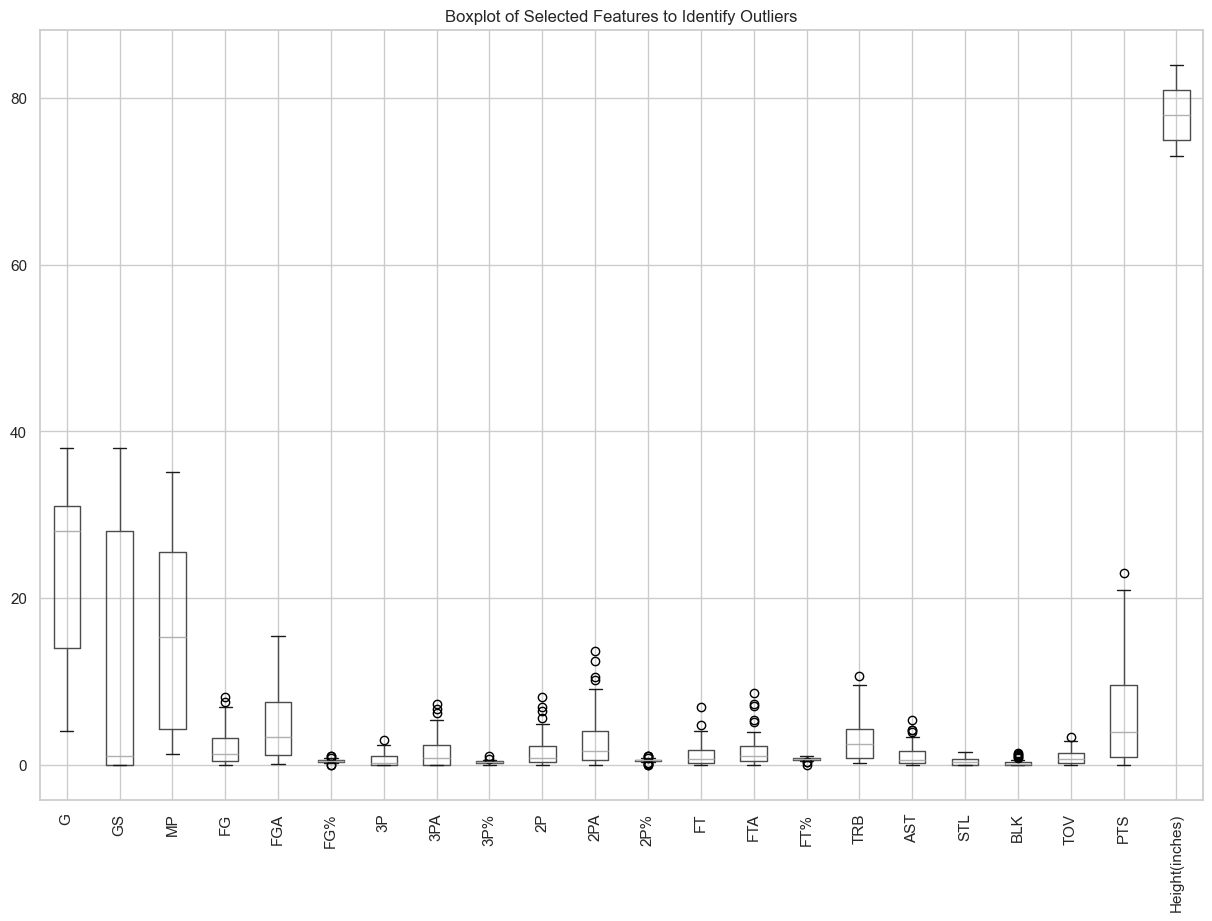

In [ ]:
# looking for outliers within specific features

plt.figure(figsize=(15, 10))
df_selected_outliers.boxplot()
plt.xticks(rotation = 90) 
plt.title("Boxplot of Selected Features to Identify Outliers")
plt.show()

In [ ]:
from scipy.stats import zscore

z_scores = df_selected_outliers.select_dtypes(include=['float64', 'int']).apply(zscore)

outliers = (z_scores.abs() > 3).any(axis=1)
df_outliers = df_selected_outliers[outliers]
df_outliers

,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,TRB,AST,STL,BLK,TOV,PTS,Height(inches)
14,Ayo Dosunmu,G,28.0,28.0,35.1,7.5,15.4,0.488,1.1,2.9,0.39,6.4,12.4,0.511,4.0,5.1,0.783,6.3,5.3,1.1,0.2,3.3,20.1,77


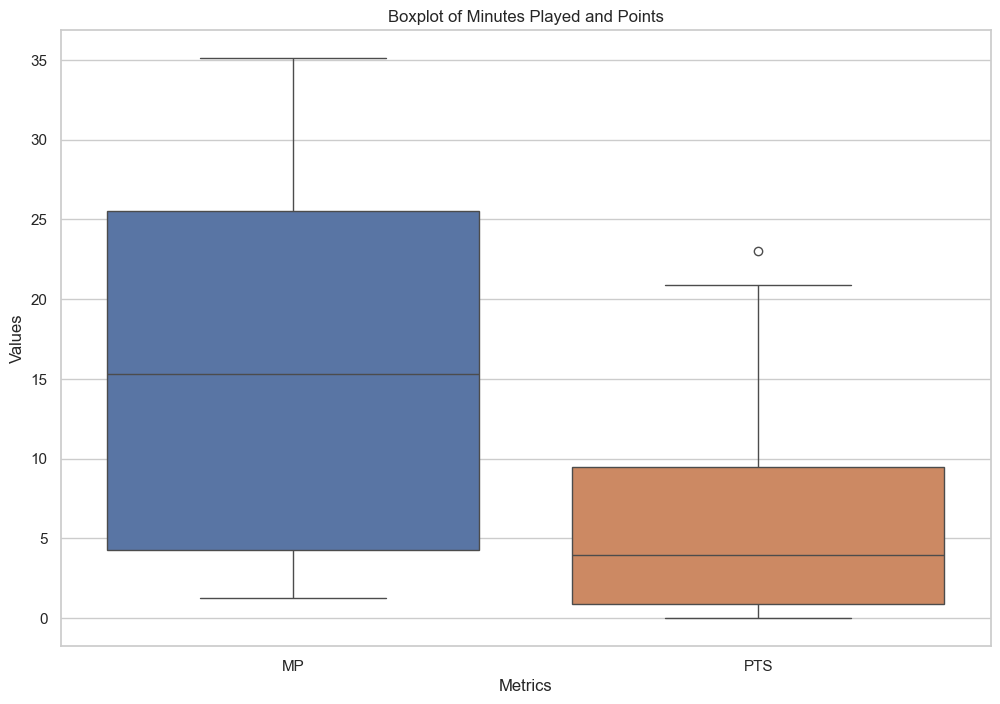

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected_outliers[['MP', 'PTS']])
plt.title("Boxplot of Minutes Played and Points")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.show()

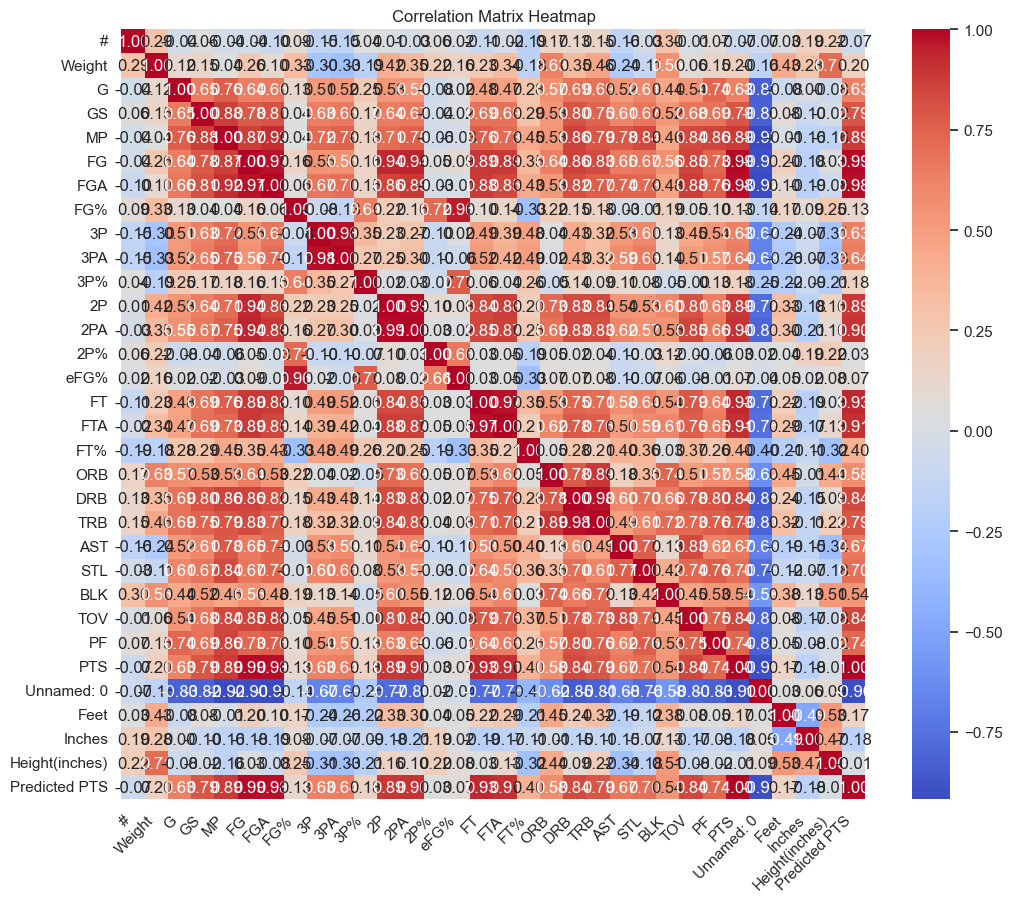

In [ ]:
numeric_roster = all_rosters.select_dtypes(include=[np.number])
corr = numeric_roster.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap')
plt.show()